<div style="text-align: justify">
<font size=6><br><h2 align="center">Detección de las conductas distractoras al conducir un automóvil </h2></font>
<font size=5><br>
<h3 align="center">Inteligencia Artificial II</h3></font><font size=5>
<h3 align="center">Proyecto Final</h3></font> 
    
<br/>

<font size=5><h4 align="left">Intregrantes: </h4></font>      
2172016 - Kevin Javier Lozano Galvis<br><br>
2170688 - Brayan Rodolfo Barajas Ochoa<br>

# Librerias

In [1]:
import os
import cv2
import glob
import random
import numpy as np
import pandas as pd 
import seaborn as sns
import tensorflow as tf
from skimage import color
import matplotlib.pyplot as plt
from dask.array.image import imread
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator

In [2]:
!pip install --upgrade --force-reinstall --no-deps kaggle

     |████████████████████████████████| 61kB 4.2MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.10-cp37-none-any.whl size=73269 sha256=ed69a4ff6d3c09f1e9e51a4afd42581b5a99faa31dbc7431f4a61231e385b9fe
  Stored in directory: /root/.cache/pip/wheels/3a/d1/7e/6ce09b72b770149802c653a02783821629146983ee5a360f10
Successfully built kaggle
  Found existing installation: kaggle 1.5.10
    Uninstalling kaggle-1.5.10:
      Successfully uninstalled kaggle-1.5.10


In [3]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"kevinlozanogalvis","key":"7aa893581a3e3a99473c2eda021232eb"}'}

In [4]:
!ls -lha kaggle.json
!mkdir -p ~/.kaggle/
!cp kaggle.json ~/.kaggle
!chmod 600 ~/.kaggle/kaggle.json

-rw-r--r-- 1 root root 73 Mar 10 16:46 kaggle.json


In [5]:
!pip install -q kaggle

In [6]:
!kaggle competitions download -c state-farm-distracted-driver-detection -p imgs

100% 4.00G/4.00G [01:12<00:00, 59.9MB/s]
100% 4.00G/4.00G [01:12<00:00, 59.3MB/s]


In [7]:
cd imgs

/content/imgs


In [8]:
!unzip state-farm-distracted-driver-detection.zip -d /content

Se han truncado las últimas 5000 líneas del flujo de salida.
  inflating: /content/imgs/train/c7/img_56636.jpg  
  inflating: /content/imgs/train/c7/img_56661.jpg  
  inflating: /content/imgs/train/c7/img_56699.jpg  
  inflating: /content/imgs/train/c7/img_56717.jpg  
  inflating: /content/imgs/train/c7/img_56724.jpg  
  inflating: /content/imgs/train/c7/img_56768.jpg  
  inflating: /content/imgs/train/c7/img_56779.jpg  
  inflating: /content/imgs/train/c7/img_56849.jpg  
  inflating: /content/imgs/train/c7/img_56899.jpg  
  inflating: /content/imgs/train/c7/img_56938.jpg  
  inflating: /content/imgs/train/c7/img_5706.jpg  
  inflating: /content/imgs/train/c7/img_57076.jpg  
  inflating: /content/imgs/train/c7/img_57122.jpg  
  inflating: /content/imgs/train/c7/img_57137.jpg  
  inflating: /content/imgs/train/c7/img_5715.jpg  
  inflating: /content/imgs/train/c7/img_57278.jpg  
  inflating: /content/imgs/train/c7/img_57321.jpg  
  inflating: /content/imgs/train/c7/img_57345.jpg  
  inf

In [9]:
%pwd

'/content/imgs'

In [10]:
!rm state-farm-distracted-driver-detection.zip

In [11]:
%ls /content

driver_imgs_list.csv  imgs/  kaggle.json  sample_data/  sample_submission.csv


In [12]:
df = pd.read_csv("../driver_imgs_list.csv")
df.head()

,subject,classname,img
0,p002,c0,img_44733.jpg
1,p002,c0,img_72999.jpg
2,p002,c0,img_25094.jpg
3,p002,c0,img_69092.jpg
4,p002,c0,img_92629.jpg


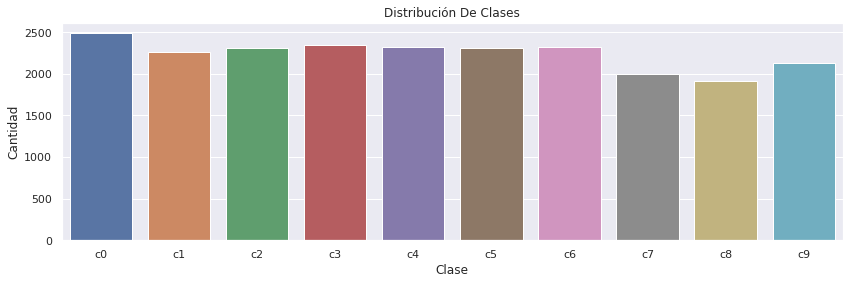

In [13]:
sns.set()
plt.figure(figsize = (14,4))
sns.countplot(x = 'classname',data = df)
plt.title('Distribución de Clases'.title())
plt.xlabel('Clase')
plt.ylabel('Cantidad')

plt.show()

In [14]:
categor = {'c0': 'Safe driving', 
           'c1': 'Texting - right', 
           'c2': 'Talking on the phone - right', 
           'c3': 'Texting - left', 
           'c4': 'Talking on the phone - left', 
           'c5': 'Operating the radio', 
           'c6': 'Drinking', 
           'c7': 'Reaching behind', 
           'c8': 'Hair and makeup', 
           'c9': 'Talking to passenger'}

In [15]:
# Imágenes del dataset
f, ax = plt.subplots(1,3, figsize = (25,25))
for i in range(3):
    labels = imread("/content/imgs/train/c"+str(i)+"/*.jpg")
    for j in range(1):
        img = labels[j]
        label = i
        ax[i].axis('off')
        ax[i].imshow(img)
        ax[i].set_title(categor['c'+str(i)])
        plt.show

# Algunos ejemplos de como van a quedar las imágenes 
f, ax = plt.subplots(1,3, figsize = (40,40))
for i in range(3):
    labels = imread("/content/imgs/train/c"+str(i)+"/*.jpg")
    for j in range(1):
        img = labels[j]
        img = img[5:,100:-10]
        label = i
        ax[i].axis('off')
        ax[i].imshow(img)
        ax[i].set_title(categor['c'+str(i)])
        plt.show

Output hidden; open in https://colab.research.google.com to view.

# Procesamiento de Datos

In [16]:
driver_details = pd.read_csv('/content/driver_imgs_list.csv',na_values='na')
driver_details.head()

,subject,classname,img
0,p002,c0,img_44733.jpg
1,p002,c0,img_72999.jpg
2,p002,c0,img_25094.jpg
3,p002,c0,img_69092.jpg
4,p002,c0,img_92629.jpg


In [17]:
train_image = []
image_label = []

for i in range(10):
    print('Class C',i)
    imgs = os.listdir("/content/imgs/train/c"+str(i))
    for j in range(len(imgs)):
        img_name = "/content/imgs/train/c"+str(i)+"/"+imgs[j]
        img = cv2.imread(img_name)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = img[5:,100:-10]
        img = cv2.resize(img,(128,128))
        label = i
        driver = driver_details[driver_details['img'] == imgs[j]]['subject'].values[0]
        train_image.append([img,label,driver])
        image_label.append(i)

Class C 0
Class C 1
Class C 2
Class C 3
Class C 4
Class C 5
Class C 6
Class C 7
Class C 8
Class C 9


In [18]:
random.seed(10)
random.shuffle(train_image)

In [19]:
D = []
for features,labels,drivers in train_image:
    D.append(drivers)

In [20]:
deduped = []

for i in D:
    if i not in deduped:
        deduped.append(i)

In [21]:
driv_selected = []
driv_nums = random.sample(range(len(deduped)), 5)
for i in driv_nums:
    driv_selected.append(deduped[i])

In [22]:
X_train= []; y_train = []; X_test = []; y_test = []; D_train = []; D_test = []

for features,labels,drivers in train_image:
    if drivers in driv_selected:
        X_test.append(features)
        y_test.append(labels)
        D_test.append(drivers)
    
    else:
        X_train.append(features)
        y_train.append(labels)
        D_train.append(drivers)
    
print (len(X_train),len(X_test))
print (len(y_train),len(y_test))

17630 4794
17630 4794


In [23]:
X_train = np.array(X_train).reshape(-1,128,128,3)
X_test = np.array(X_test).reshape(-1,128,128,3)

X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255

y_train = tf.keras.utils.to_categorical(y_train)
y_test = tf.keras.utils.to_categorical(y_test)

print (X_train.shape)

(17630, 128, 128, 3)


# Data Augmentation

In [24]:
datagen = ImageDataGenerator(width_shift_range=0.2, height_shift_range=0.2, zoom_range=0.1, rotation_range=20)
datagen.fit(X_train)

In [25]:
training = datagen.flow(X_train, y_train, batch_size=128)

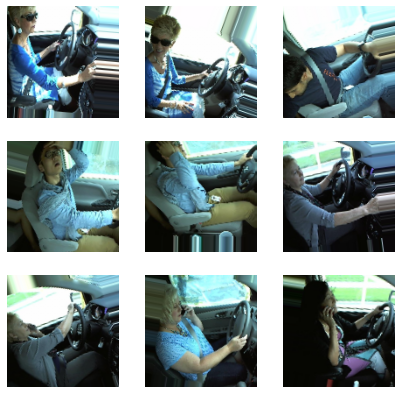

In [26]:
plt.figure(figsize=(7,7));
plt.xticks([]);
plt.yticks([]);
plt.grid(False);

for X_batch, y_batch in datagen.flow(X_train, y_train, batch_size=9):
    for i in range(9):
      plt.subplot(330 + 1 + i)
      plt.imshow(X_batch[i].reshape(128, 128, 3), cmap=plt.cm.binary);
      plt.axis('off')
    plt.show()
    break

# Modelo Creado CNN 

In [55]:
model_CNN = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (5,5), input_shape = (128 , 128 , 3), activation = 'relu',  kernel_initializer='he_uniform', bias_initializer='he_uniform', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(3,3),
    tf.keras.layers.Conv2D(64, (5,5) , activation = 'relu', kernel_initializer='he_uniform', bias_initializer='he_uniform', padding='same'),
    tf.keras.layers.MaxPooling2D((3,3)),
    tf.keras.layers.Conv2D(128, (5,5) , activation = 'relu', kernel_initializer='he_uniform', bias_initializer='he_uniform', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(3,3),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(64 , activation = 'relu',kernel_initializer='he_uniform', bias_initializer='he_uniform'),
    tf.keras.layers.Dense(10, activation = 'softmax')])

In [56]:
model_CNN.compile(loss = 'categorical_crossentropy' , optimizer = tf.keras.optimizers.SGD(lr = 0.001) , metrics = 'accuracy')
model_CNN.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 128, 128, 32)      2432      
_________________________________________________________________
batch_normalization_2 (Batch (None, 128, 128, 32)      128       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 42, 42, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 42, 42, 64)        51264     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 14, 14, 128)       204928    
_________________________________________________________________
batch_normalization_3 (Batch (None, 14, 14, 128)      

In [57]:
history = model_CNN.fit(X_train , y_train, epochs = 20, batch_size=128, validation_data=(X_test, y_test)) 

Epoch 1/20
138/138 [==============================] - 7s 41ms/step - loss: 2.6734 - accuracy: 0.1573 - val_loss: 2.3568 - val_accuracy: 0.1270
Epoch 2/20
138/138 [==============================] - 5s 39ms/step - loss: 1.8622 - accuracy: 0.3566 - val_loss: 2.2740 - val_accuracy: 0.1877
Epoch 3/20
138/138 [==============================] - 5s 40ms/step - loss: 1.4748 - accuracy: 0.5209 - val_loss: 2.2439 - val_accuracy: 0.2232
Epoch 4/20
138/138 [==============================] - 5s 39ms/step - loss: 1.1137 - accuracy: 0.6517 - val_loss: 2.1934 - val_accuracy: 0.2680
Epoch 5/20
138/138 [==============================] - 5s 39ms/step - loss: 0.8541 - accuracy: 0.7445 - val_loss: 2.2509 - val_accuracy: 0.2866
Epoch 6/20
138/138 [==============================] - 5s 40ms/step - loss: 0.6300 - accuracy: 0.8209 - val_loss: 2.1770 - val_accuracy: 0.2966
Epoch 7/20
138/138 [==============================] - 5s 40ms/step - loss: 0.5052 - accuracy: 0.8606 - val_loss: 2.1417 - val_accuracy: 0.3164

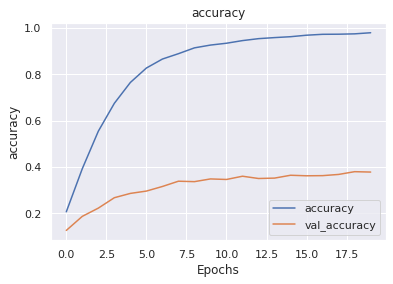

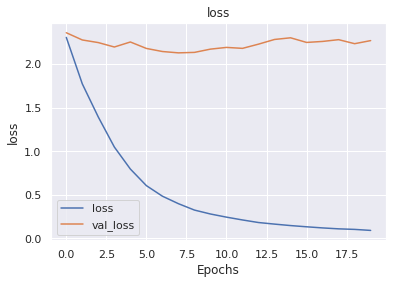

In [58]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.title(string)
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

# Transfer Learning VGG16 con Data Augmentation

In [ ]:
model_VGG16_da =  tf.keras.applications.VGG16(include_top=False,input_shape=(128,128,3), weights='imagenet')
model_VGG16_da.trainable = True
print("Total layers of VGG16: ", len(model_VGG16_da.layers))

Total layers of VGG16:  19


In [ ]:
for layer in model_VGG16_da.layers[:12]:
  layer.trainable =  False

model_VGG16_da.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 32, 128)       0     

In [ ]:
model_cnn_VGG16_da = tf.keras.models.Sequential([
    model_VGG16_da,
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Conv2D(512, (1,1) , activation = 'relu', kernel_initializer='he_uniform', bias_initializer='he_uniform', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(10, activation='softmax')
])

model_cnn_VGG16_da.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
dropout_11 (Dropout)         (None, 4, 4, 512)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 4, 4, 512)         262656    
_________________________________________________________________
batch_normalization_3 (Batch (None, 4, 4, 512)         2048      
_________________________________________________________________
flatten_8 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 8192)              0         
_________________________________________________________________
dense_13 (Dense)             (None, 10)               

In [ ]:
checkpointer = tf.keras.callbacks.ModelCheckpoint('Models/model_VGG16.hdf5', verbose=1, save_best_only=True)
earlystopper = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1)

In [ ]:
learning_rate= 0.0004
opt = tf.keras.optimizers.SGD(learning_rate)
model_cnn_VGG16_da.compile(optimizer=opt, loss='categorical_crossentropy',metrics=['accuracy'])
history = model_cnn_VGG16_da.fit(training,  steps_per_epoch = len(X_train)/128, callbacks=[checkpointer, earlystopper], epochs = 20, verbose=1,validation_data=(X_test, y_test))

Epoch 1/20
137/137 [==============================] - 71s 506ms/step - loss: 3.2255 - accuracy: 0.1129 - val_loss: 2.1099 - val_accuracy: 0.2681

Epoch 00001: val_loss improved from inf to 2.10994, saving model to Models/model_VGG16.hdf5
Epoch 2/20
137/137 [==============================] - 70s 505ms/step - loss: 2.6748 - accuracy: 0.1786 - val_loss: 1.7059 - val_accuracy: 0.4838

Epoch 00002: val_loss improved from 2.10994 to 1.70588, saving model to Models/model_VGG16.hdf5
Epoch 3/20
137/137 [==============================] - 70s 505ms/step - loss: 2.2070 - accuracy: 0.2818 - val_loss: 1.2768 - val_accuracy: 0.6171

Epoch 00003: val_loss improved from 1.70588 to 1.27675, saving model to Models/model_VGG16.hdf5
Epoch 4/20
137/137 [==============================] - 69s 505ms/step - loss: 1.7347 - accuracy: 0.4077 - val_loss: 1.0301 - val_accuracy: 0.6825

Epoch 00004: val_loss improved from 1.27675 to 1.03015, saving model to Models/model_VGG16.hdf5
Epoch 5/20
137/137 [================

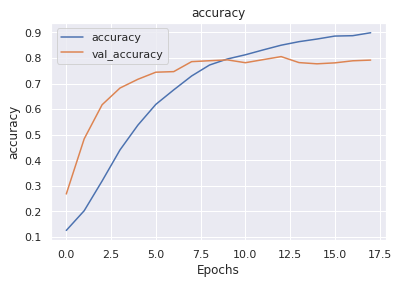

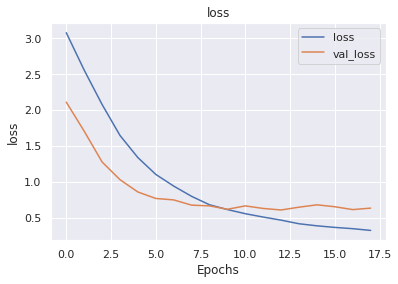

In [ ]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.title(string)
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

# Transfer Learning VGG19 con Data Augmentation

In [ ]:
model_VGG19 =  tf.keras.applications.VGG19(include_top=False,input_shape=(128,128,3), weights='imagenet')
model_VGG19.trainable = True
print("Total layers of VGG19: ", len(model_VGG19.layers))

Total layers of VGG19:  22


In [ ]:
for layer in model_VGG19.layers[:12]:
  layer.trainable =  False

model_VGG19.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 32, 128)       0     

In [ ]:
model_cnn_VGG19 = tf.keras.models.Sequential([
    model_VGG19,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(64 , activation = 'relu',kernel_initializer='he_uniform', bias_initializer='he_uniform'),
    tf.keras.layers.Dense(10, activation='softmax')
])

model_cnn_VGG19.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 4, 4, 512)         20024384  
_________________________________________________________________
flatten_3 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 8192)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 64)                524352    
_________________________________________________________________
dense_7 (Dense)              (None, 10)                650       
Total params: 20,549,386
Trainable params: 18,223,818
Non-trainable params: 2,325,568
_________________________________________________________________


In [ ]:
checkpointer = tf.keras.callbacks.ModelCheckpoint('Models/model_VGG19_2.hdf5', verbose=1, save_best_only=True)
earlystopper = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1)

In [ ]:
learning_rate= 0.0005
opt = tf.keras.optimizers.SGD(learning_rate)
model_cnn_VGG19.compile(optimizer=opt, loss='categorical_crossentropy',metrics=['accuracy'])
history = model_cnn_VGG19.fit(training,  steps_per_epoch = len(X_train)/128, callbacks=[checkpointer, earlystopper], epochs = 20, verbose=1,validation_data=(X_test, y_test))

Epoch 1/20
137/137 [==============================] - 73s 522ms/step - loss: 2.5154 - accuracy: 0.1113 - val_loss: 2.2559 - val_accuracy: 0.1651

Epoch 00001: val_loss improved from inf to 2.25587, saving model to Models/model_VGG19_2.hdf5
Epoch 2/20
137/137 [==============================] - 72s 523ms/step - loss: 2.3210 - accuracy: 0.1276 - val_loss: 2.2209 - val_accuracy: 0.2265

Epoch 00002: val_loss improved from 2.25587 to 2.22090, saving model to Models/model_VGG19_2.hdf5
Epoch 3/20
137/137 [==============================] - 72s 524ms/step - loss: 2.2525 - accuracy: 0.1614 - val_loss: 2.1275 - val_accuracy: 0.3324

Epoch 00003: val_loss improved from 2.22090 to 2.12753, saving model to Models/model_VGG19_2.hdf5
Epoch 4/20
137/137 [==============================] - 72s 523ms/step - loss: 2.1380 - accuracy: 0.2297 - val_loss: 1.8763 - val_accuracy: 0.4446

Epoch 00004: val_loss improved from 2.12753 to 1.87629, saving model to Models/model_VGG19_2.hdf5
Epoch 5/20
137/137 [========

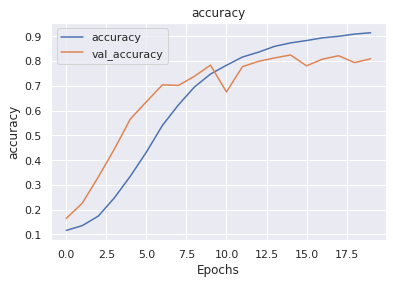

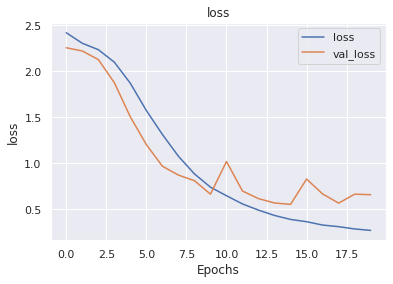

In [ ]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.title(string)
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

# Transfer Learning DenseNet169 con Data Augmentation

In [ ]:
model_DenseNet169 =  tf.keras.applications.DenseNet169(include_top=False,input_shape=(128,128,3), weights='imagenet')
model_DenseNet169.trainable = True
print("Total layers of DenseNet169: ", len(model_DenseNet169.layers))

51879936/51877672 [==============================] - 1s 0us/step
Total layers of DenseNet169:  595


In [ ]:
for layer in model_DenseNet169.layers[:195]:
 layer.trainable =  False

model_DenseNet169.summary()

Model: "densenet169"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 134, 134, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 64, 64, 64)   9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 64, 64, 64)   256         conv1/conv[0][0]                 
________________________________________________________________________________________

In [ ]:
model_cnn_DenseNet169 = tf.keras.models.Sequential([
    model_DenseNet169,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(10, activation='softmax')
])

model_cnn_DenseNet169.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet169 (Functional)     (None, 4, 4, 1664)        12642880  
_________________________________________________________________
flatten_6 (Flatten)          (None, 26624)             0         
_________________________________________________________________
dense_13 (Dense)             (None, 256)               6816000   
_________________________________________________________________
dropout_7 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 128)               32896     
_________________________________________________________________
dropout_8 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_15 (Dense)             (None, 10)               

In [ ]:
checkpointer = tf.keras.callbacks.ModelCheckpoint('Models/model_DenseNet169.hdf5', verbose=1, save_best_only=True)
earlystopper = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1)

In [ ]:
learning_rate= 0.002
opt = tf.keras.optimizers.SGD(learning_rate)
model_cnn_DenseNet169.compile(optimizer=opt, loss='categorical_crossentropy',metrics=['accuracy'])
history = model_cnn_DenseNet169.fit(training,  steps_per_epoch = len(X_train)/128, callbacks=[checkpointer, earlystopper], epochs = 30, verbose=1,validation_data=(X_test, y_test))

Epoch 1/30
137/137 [==============================] - 75s 464ms/step - loss: 2.4826 - accuracy: 0.1387 - val_loss: 2.0087 - val_accuracy: 0.3033

Epoch 00001: val_loss improved from inf to 2.00867, saving model to Models/model_DenseNet169.hdf5
Epoch 2/30
137/137 [==============================] - 60s 436ms/step - loss: 1.8775 - accuracy: 0.3449 - val_loss: 1.4571 - val_accuracy: 0.4937

Epoch 00002: val_loss improved from 2.00867 to 1.45712, saving model to Models/model_DenseNet169.hdf5
Epoch 3/30
137/137 [==============================] - 60s 438ms/step - loss: 1.2526 - accuracy: 0.5770 - val_loss: 1.0051 - val_accuracy: 0.6464

Epoch 00003: val_loss improved from 1.45712 to 1.00510, saving model to Models/model_DenseNet169.hdf5
Epoch 4/30
137/137 [==============================] - 60s 437ms/step - loss: 0.8007 - accuracy: 0.7351 - val_loss: 0.8108 - val_accuracy: 0.7194

Epoch 00004: val_loss improved from 1.00510 to 0.81077, saving model to Models/model_DenseNet169.hdf5
Epoch 5/30
1

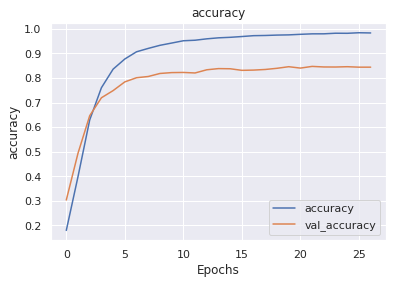

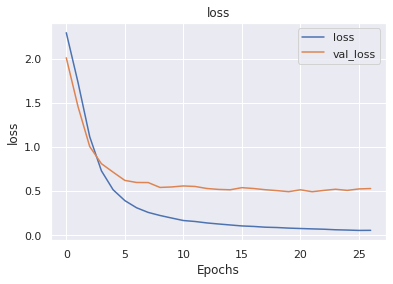

In [ ]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.title(string)
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

# Resultados

In [41]:
import os
modelos.append(tf.keras.models.load_model('/content/imgs/Models/model_VGG19.hdf5'))

In [42]:
import sklearn.metrics as metrics
y_pred = modelos[0].predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)
print('Classification Report ' + model_names[0])
report = metrics.classification_report(y_true, y_pred)
print(report) 

Classification Report model_VGG19.hdf5
              precision    recall  f1-score   support

           0       0.87      0.88      0.88       534
           1       0.95      1.00      0.97       465
           2       0.96      0.94      0.95       475
           3       0.92      0.99      0.95       519
           4       0.97      0.96      0.97       493
           5       1.00      0.99      1.00       510
           6       0.99      0.92      0.95       499
           7       0.97      0.99      0.98       429
           8       0.86      0.86      0.86       413
           9       0.87      0.82      0.85       457

    accuracy                           0.94      4794
   macro avg       0.94      0.93      0.93      4794
weighted avg       0.94      0.94      0.94      4794



In [43]:
!pip install --upgrade --force-reinstall --no-deps scikit-plot

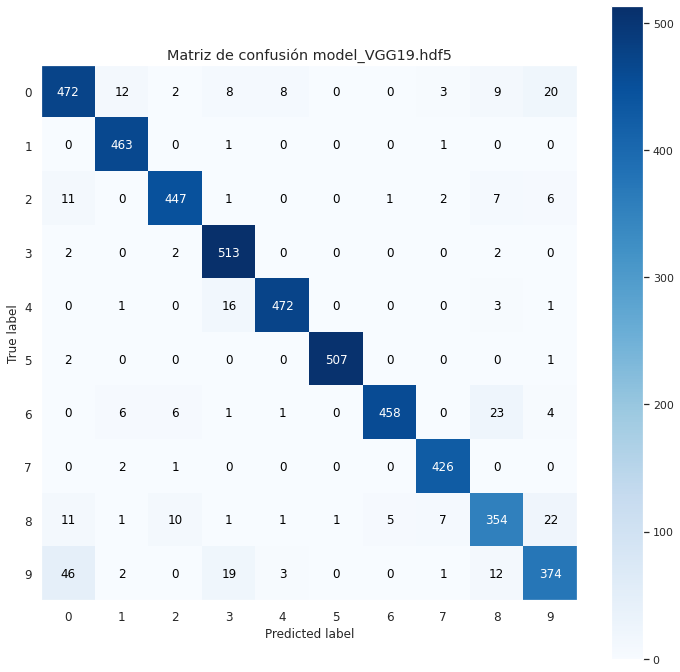

In [44]:
import scikitplot as skplt

skplt.metrics.plot_confusion_matrix(
    np.argmax(y_test, axis=1), y_pred,
    figsize=(12,12), title="Matriz de confusión "+model_names[0])

In [45]:
modelos.append(tf.keras.models.load_model('/content/imgs/Models/model_DenseNet169.hdf5'))

In [46]:
import sklearn.metrics as metrics
y_pred = modelos[1].predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)
print('Classification Report ' + model_names[1])
report = metrics.classification_report(y_true, y_pred)
print(report) 

Classification Report model_DenseNet169.hdf5
              precision    recall  f1-score   support

           0       0.75      0.73      0.74       534
           1       0.95      0.92      0.93       465
           2       0.79      0.81      0.80       475
           3       0.86      0.97      0.91       519
           4       0.96      0.85      0.90       493
           5       0.92      0.97      0.95       510
           6       0.99      0.83      0.90       499
           7       0.95      0.93      0.94       429
           8       0.65      0.86      0.74       413
           9       0.70      0.59      0.64       457

    accuracy                           0.85      4794
   macro avg       0.85      0.85      0.85      4794
weighted avg       0.85      0.85      0.85      4794



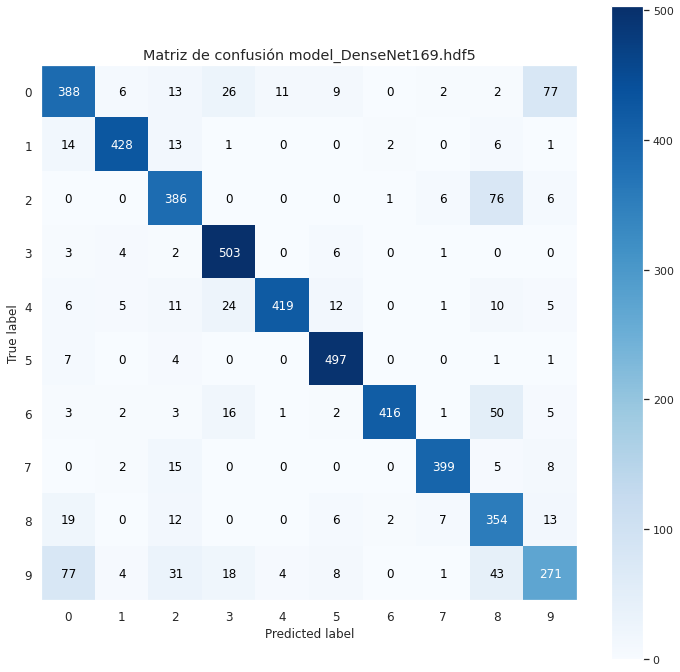

In [47]:
skplt.metrics.plot_confusion_matrix(
    np.argmax(y_test, axis=1), y_pred,
    figsize=(12,12), title="Matriz de confusión "+model_names[1])

# Resultados experimentales

In [48]:
model_cnn_VGG19 = tf.keras.models.load_model('/content/imgs/Models/model_VGG19.hdf5')

Image number: 0
Image number: 1
Image number: 2
Image number: 3
Image number: 4
Image number: 5
Image number: 6
Image number: 7
Image number: 8
Image number: 9


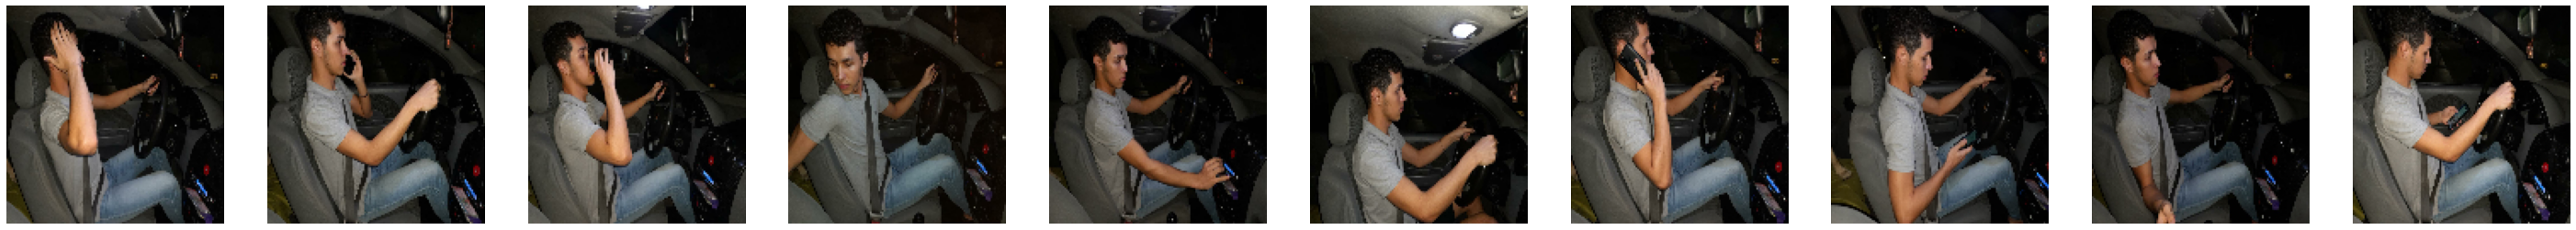

In [49]:
test_image = []
i = 0
fig, ax = plt.subplots(1, 10, figsize = (50,50))

files = os.listdir('/content/imgs/experimental/')
for i in range(10):
    print ('Image number:',i)
    img = cv2.imread('/content/imgs/experimental/'+files[i])
    img = cv2.resize(img,(128,128))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    test_image.append(img)
    ax[i].imshow(img)
    ax[i].axis('off')
    plt.show

In [50]:
test = []

for img in test_image:
    test.append(img)

test = np.array(test).reshape(-1,128,128,3)
test = test.astype('float32')/255.
prediction = model_cnn_VGG19.predict(test)

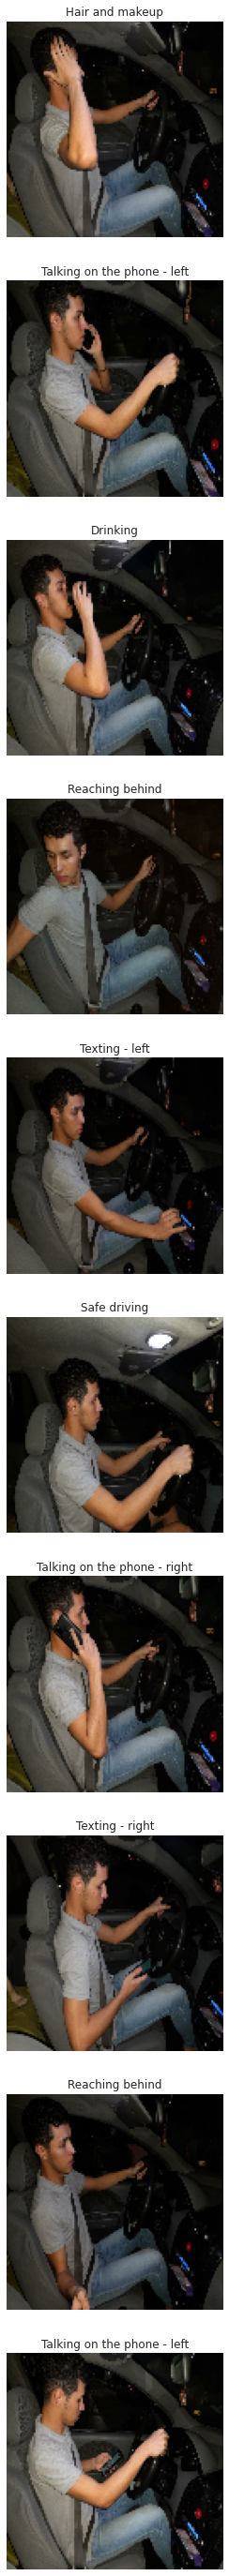

In [51]:
i = 0
fig, ax = plt.subplots(10, 1, figsize = (50,50 ))

for i in range(10):
    ax[i].imshow(test[i].squeeze())
    predicted_class = 'c'+str(np.where(prediction[i] == np.amax(prediction[i]))[0][0])
    ax[i].set_title(categor[predicted_class])
    ax[i].axis('off')
    plt.show

In [52]:
model_cnn_DenseNet169 = tf.keras.models.load_model('/content/imgs/Models/model_DenseNet169.hdf5')

In [53]:
test = []

for img in test_image:
    test.append(img)

test = np.array(test).reshape(-1,128,128,3)
test = test.astype('float32')/255.
prediction = model_cnn_DenseNet169.predict(test)

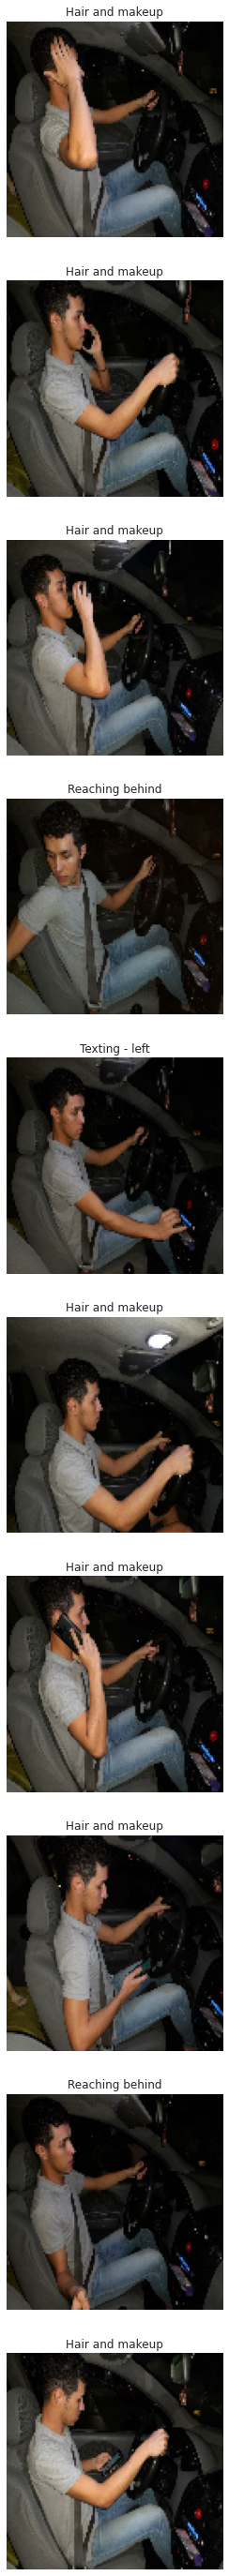

In [54]:
i = 0
fig, ax = plt.subplots(10, 1, figsize = (50,50 ))

for i in range(10):
    ax[i].imshow(test[i].squeeze())
    predicted_class = 'c'+str(np.where(prediction[i] == np.amax(prediction[i]))[0][0])
    ax[i].set_title(categor[predicted_class])
    ax[i].axis('off')
    plt.show

# Generando CSV para Kaggle, para evaluar los datos no etiquetados

In [ ]:
model_cnn_VGG19 = tf.keras.models.load_model('/content/imgs/Models/model_VGG19.hdf5')

In [ ]:
predicts = []
imgs_test = os.listdir("test")
n = len(imgs_test)

In [ ]:
from tqdm import tqdm

In [ ]:
for i in range(0,4):
  for f in tqdm(range(int(n/4*i),int(n/4*(i+1)))):
    temp_img = cv2.cvtColor(cv2.imread("test/"+imgs_test[f]), cv2.COLOR_BGR2RGB)
    temp_img = temp_img[5:,100:-10]
    temp_img = np.array(cv2.resize(temp_img,(128,128))).reshape(-1,128,128,3)
    temp_img = temp_img.astype('float32') / 255
    temp_predict = model_cnn_VGG19.predict(temp_img)
    predicts.append(np.append(imgs_test[f],temp_predict))

In [ ]:
import csv

In [ ]:
fields = ['img','c0','c1','c2','c3','c4','c5','c6','c7','c8','c9']  
    
# data rows of csv file  
with open('../submission_model_cnn_VGG19.csv', 'w') as f: 
      
    # using csv.writer method from CSV package 
    write = csv.writer(f) 
      
    write.writerow(fields) 
    write.writerows(predicts)

In [32]:
model_DenseNet169 = tf.keras.models.load_model('/content/imgs/Models/model_DenseNet169.hdf5')

In [33]:
predicts = []
imgs_test = os.listdir("test")
n = len(imgs_test)

In [35]:
for i in range(0,4):
  for f in tqdm(range(int(n/4*i),int(n/4*(i+1)))):
    temp_img = cv2.cvtColor(cv2.imread("test/"+imgs_test[f]), cv2.COLOR_BGR2RGB)
    temp_img = temp_img[5:,100:-10]
    temp_img = np.array(cv2.resize(temp_img,(128,128))).reshape(-1,128,128,3)
    temp_img = temp_img.astype('float32') / 255
    temp_predict = model_DenseNet169.predict(temp_img)
    predicts.append(np.append(imgs_test[f],temp_predict))

100%|██████████| 19932/19932 [23:27<00:00, 14.16it/s]


In [37]:
fields = ['img','c0','c1','c2','c3','c4','c5','c6','c7','c8','c9']  
    
# data rows of csv file  
with open('../submission_DenseNet169.csv', 'w') as f: 
      
    # using csv.writer method from CSV package 
    write = csv.writer(f) 
      
    write.writerow(fields) 
    write.writerows(predicts)